In [1]:
# package & setting
import os

import copy
import numpy as np
import pandas as pd
import random
from itertools import cycle

from sklearn import model_selection

from sklearn import metrics

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import neighbors

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, roc_curve, auc

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras

from plotly import graph_objects as go
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import re

import warnings 

warnings.filterwarnings('ignore')

plt.rc('font', family='Arial')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# file path
read_path = r'/Users/rachel_gao/Desktop/Booking Trend/booking_trend.xlsx'
data = pd.read_excel(read_path)

print('row:', data.shape[0], 'column:',data.shape[1])
print(list(data))

row: 10600 column: 17
['booking_id', 'sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'weight_kg', 'volume_cbm', 'booking_system', 'lead_time', 'departure_date', 'cancel_status', 'final_sort_type', 'seller_type', 'gl_product_group_desc', 'booking_type', 'seqnum']


In [3]:
# clean data
data = data.drop(['booking_type', 'seqnum'], axis=1)
data = data.drop((data[data['volume_cbm'] >= 4000]).index, axis=0)
data = data.drop((data[data['departure_date'] < "2020/1/1 00:00:00"]).index, axis=0)

# missing value
na_num = data.isnull().sum()
na_num = na_num[na_num!=0]
na_percent = data.isnull().sum() / data.shape[0]
na_percent = na_percent[na_percent!=0]
na={"na_num": na_num,"na_percent": na_percent}
na=pd.DataFrame(na)
na

,na_num,na_percent
pod,22,0.002368
departure_date,1,0.000108
gl_product_group_desc,129,0.013886


In [4]:
# drop na
data.dropna(axis=0, how='any', inplace=True)
print('row:', data.shape[0], 'column:',data.shape[1])

row: 9138 column: 15


In [5]:
# data type
nominal = ['booking_id', 'sales_team', 'pol', 'pod', 'trans_mode', 'shipment_type', 'booking_system', 
           'cancel_status', 'final_sort_type', 'seller_type', 'gl_product_group_desc']
interval = ['weight_kg', 'volume_cbm', 'lead_time', 'departure_date']

# Description

In [6]:
# sales_team
pd.DataFrame(data.groupby(['sales_team']).size()).sort_values(0, axis=0)

,0
sales_team,
EU DSR,26
US DSR,90
CN DSR,9022


In [7]:
# pol
pd.DataFrame(data.groupby(['pol']).size()).sort_values(0, axis=0)

,0
pol,
CNSHK,4
CNTSN,13
CNFOC,15
XMN,15
CNTXG,18
CNZUH,34
SZX,53
CAN,66
PVG,124


In [8]:
# pod
pd.DataFrame(data.groupby(['pod']).size()).sort_values(0, axis=0)

,0
pod,
ESBCN,1
USROI,1
USRLO,1
GBLGP,1
ITGOA,1
SFO,1
USMVA,1
NRT,1
USSBT,2


In [9]:
# trans_mode
pd.DataFrame(data.groupby(['trans_mode']).size()).sort_values(0, axis=0)

,0
trans_mode,
AIR,1269
OCEAN,7869


In [10]:
# shipment_type
pd.DataFrame(data.groupby(['shipment_type']).size()).sort_values(0, axis=0)

,0
shipment_type,
AIR,1269
LCL,2639
FCL,5230


In [11]:
# booking_system
pd.DataFrame(data.groupby(['booking_system']).size()).sort_values(0, axis=0)

,0
booking_system,
SC,1316
AGL,7822


In [12]:
# cancel_status
pd.DataFrame(data.groupby(['cancel_status']).size()).sort_values(0, axis=0)

,0
cancel_status,
Y,2
N,9136


In [13]:
# final_sort_type
pd.DataFrame(data.groupby(['final_sort_type']).size()).sort_values(0, axis=0)

,0
final_sort_type,
HeavyBulky,2
HB,100
NonSort,1832
Sort,7204


In [14]:
# seller_type
pd.DataFrame(data.groupby(['seller_type']).size()).sort_values(0, axis=0)

,0
seller_type,
Existing,2932
NEW,6206


In [15]:
# gl_product_group_desc
pd.DataFrame(data.groupby(['gl_product_group_desc']).size()).sort_values(0, axis=0)

,0
gl_product_group_desc,
unknown,1
gl_authority_non_buyable,1
gl_digital_products_3_accessory,1
gl_digital_accessories_4,2
gl_grocery,2
gl_mobile_electronics,3
gl_book,3
gl_watch,5
gl_tires,5


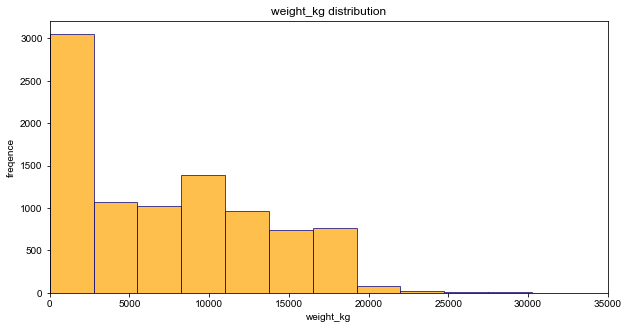

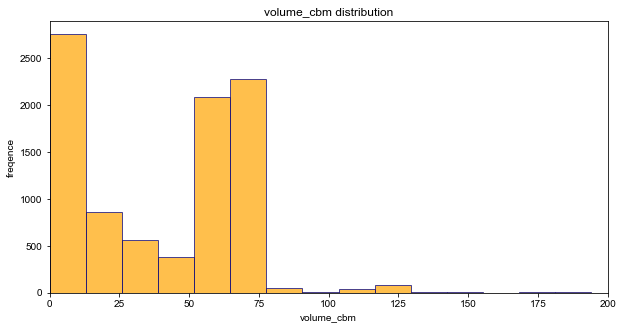

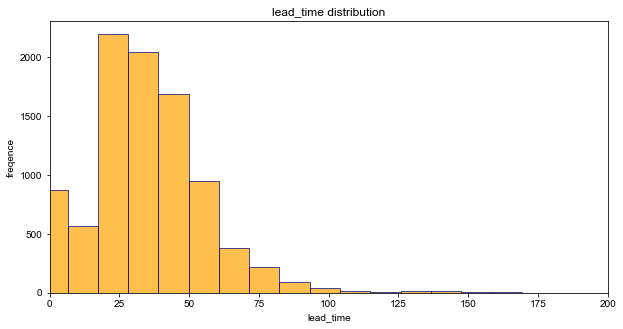

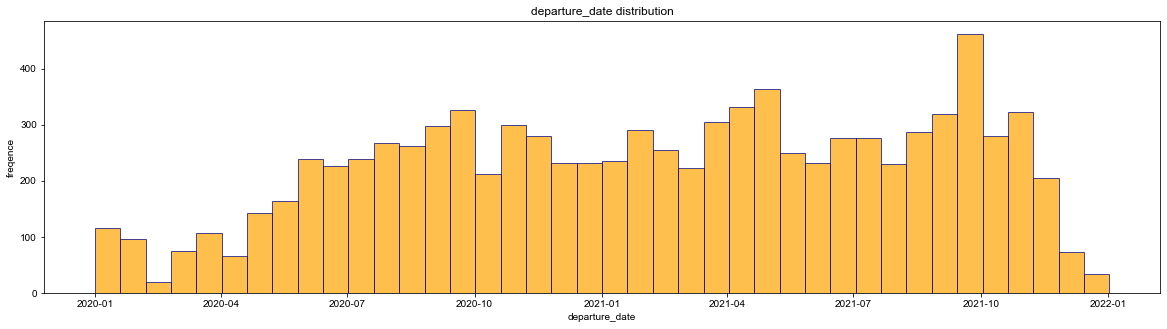

In [16]:
# weight_kg
plt.figure(figsize=(10, 5))
plt.xlim((0, 35000))
plt.hist(data['weight_kg'], bins=80, facecolor="orange", edgecolor="navy", alpha=0.7)
plt.xlabel("weight_kg")
plt.ylabel("freqence") 
plt.title("weight_kg distribution")
plt.show()

# volume_cbm
plt.figure(figsize=(10, 5))
plt.xlim((0, 200))
plt.hist(data['volume_cbm'], bins=50, facecolor="orange", edgecolor="navy", alpha=0.7)
plt.xlabel("volume_cbm")
plt.ylabel("freqence") 
plt.title("volume_cbm distribution")
plt.show()

# lead_time
plt.figure(figsize=(10, 5))
plt.xlim((0, 200))
plt.hist(data['lead_time'], bins=40, facecolor="orange", edgecolor="navy", alpha=0.7)
plt.xlabel("lead_time")
plt.ylabel("freqence") 
plt.title("lead_time distribution")
plt.show()

# departure_date
plt.figure(figsize=(20,5))
plt.hist(data['departure_date'], bins=40, facecolor="orange", edgecolor="navy", alpha=0.7)
plt.xlabel("departure_date")
plt.ylabel("freqence") 
plt.title("departure_date distribution")
plt.show()